This script is used to create the figures in extended abstract for HWRS2025

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
# from spotpy import objectivefunctions
import os

In [2]:
# TODO: Data -- observations and modelling
# Scatter plot of obs vs. mod for all years with uncertainty shown as bars
data_dir = '../output/run_till_2017_20241125/'
fig_dir = '../output/figs/'
fn_obs = 'din_obs_ensemble.csv'
fn_mod = 'Sandy_Creek.9.obs.csv'
# Read data into dataframes
din_obs = pd.read_csv(data_dir + fn_obs, index_col = 'real_name').drop('DIN_2018', axis=1)
din_mod = pd.read_csv(data_dir + fn_mod, index_col = 'real_name')
din_mod.columns = din_obs.columns
din_obs['Type'] = 'Observation'
din_mod['Type'] = 'Simulation'

# Combine to one dataframe by adding a column "Type" to distinguish between obs and mod
din_comb = pd.concat([din_obs, din_mod], axis = 0).\
    melt(id_vars = 'Type', var_name = 'Year', value_name='Annual DIN load (t)')

# Calculate uncertainty ranges  using base realisations:
# obs_err = np.abs(din_obs.loc[:, :'DIN_2017'].quantile([0.025, 0.975], axis=0) \
#                  - din_obs.loc[0, :'DIN_2017']).astype(float).round(3)
# mod_err = np.abs(din_mod.loc[:, :'DIN_2017'].quantile([0.025, 0.975], axis=0) \
#                  - din_mod.loc[0, :'DIN_2017']).astype(float).round(3)


In [3]:
# Calculate uncertainty ranges using median values:
obs_mid = din_obs.loc[:, :'DIN_2017'].median()
mod_mid = din_mod.loc[:, :'DIN_2017'].median()
# Calculate uncertainty ranges :
obs_err = np.abs(din_obs.loc[:, :'DIN_2017'].quantile([0.025, 0.975], axis=0) \
                 - obs_mid.values).astype(float).round(3)
mod_err = np.abs(din_mod.loc[:, :'DIN_2017'].quantile([0.025, 0.975], axis=0) \
                - mod_mid.values).astype(float).round(3)

Plot parameter uncertainty

In [4]:
# Read RELATIVE parameter values -- relative values that are normalized to its prior ranges
par_fn = 'Sandy_Creek.9.par.csv'
par_df = pd.read_csv(data_dir + par_fn, index_col='real_name')
par_melt = pd.melt(par_df, var_name='Parameter Name', value_name='Parameter Value')
# Read parameters prior and names; The column of ShortName will be used as the x-axis index.
default_pars = pd.read_excel('../data/default_starting_params.xlsx')

# Read ABSOLUTE parameter values -- relative values that are normalized to its prior ranges
# Calculate absolute values
abs_par_fn = 'parameter_absolute_value.csv'
if not os.path.exists(data_dir + abs_par_fn):
    abs_par_df = pd.DataFrame(index=par_df.index, columns=par_df.columns)
    for ii in range(par_df.shape[1]):
        abs_par_df.iloc[:, ii] = (par_df.iloc[:, ii] - par_df.iloc[:, ii].min())/ 100 * \
            (default_pars['max'][ii]- default_pars['min'][ii]) + \
            default_pars['min'][ii]
    abs_par_df.to_csv(data_dir + abs_par_fn)
abs_par_df = pd.read_csv(data_dir + abs_par_fn, index_col='real_name')
abs_par_melt = pd.melt(abs_par_df, var_name='Parameter Name', value_name='Parameter Value')

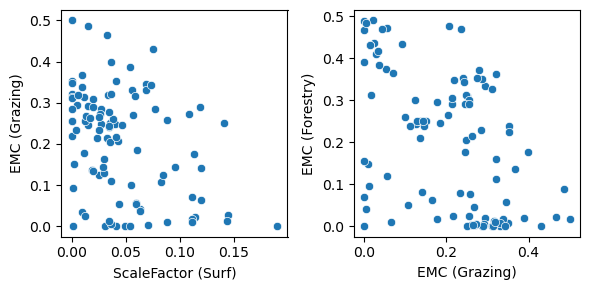

In [8]:
fig, axes = plt.subplots(nrows = 1, ncols=2, figsize=(6, 3))
sns.scatterplot(data=abs_par_df, x = 'scale_din', y = 'gemc', ax=axes[0])
sns.scatterplot(data=abs_par_df, x = 'gemc', y = 'femc', ax=axes[1])
# Customize x-axis labels for each plot
new_xlabels = [[default_pars['ShortName'][1], default_pars['ShortName'][2]],\
                [default_pars['ShortName'][2], default_pars['ShortName'][4]]]
for i, ax in enumerate(axes):
    # Change x-axis label for each subplot
    ax.set_xlabel(new_xlabels[i][0], fontsize = 10)
    ax.tick_params(labelsize = 10)
    # ax.add_patch(Rectangle((0, 0), 1, 1, fill=False, color='black', lw=2, transform=ax.transAxes))
    ax.set_ylabel(new_xlabels[i][1], fontsize = 10)

# Show the plot
plt.tight_layout()
plt.savefig(f'{fig_dir}Extended_Abstact_ParametersUnc.png', format = 'png', dpi = 300)

Plot MV curves

In [4]:
# Read cumulative of normalized data
# if use the given daily timeseries as true values
# data_dir = '../data/'
# fn_obs = 'ObsCumuFlowLoad.csv'
# df_obs = pd.read_csv(f'{data_dir}{fn_obs}');
# if using the interpolation realisations with uncertainty considered as base observations
dir = '../output/DailyData_run_till_2017_20241125/'
fn_obs = 'ObsCumuFlowLoadEnsmb.xlsx'
df_obs = pd.read_excel(f'{dir}{fn_obs}', sheet_name='RUN_1');
fn_mod = 'ModCumuFlowLoad.xlsx'
df_mod = pd.read_excel(f'{dir}{fn_mod}', sheet_name='RUN_0');

In [5]:
# TODO: Add uncertainty to double mass plot.# Select three years: 2013-2015
# Read the ensemble of normalized values for both obs and mod
# Read all sheets into a dictionary of DataFrames
df_sheets = pd.read_excel(dir + fn_mod, sheet_name=None)
norm_data_unc = {'mod':{'2016': np.zeros(shape=(365, 100))}, 
                 'obs':{'2016': np.zeros(shape=(365, 100))}}
# Iterate over each sheet (key is the sheet name, value is the DataFrame)
kk = 0
for sheet_name, df in df_sheets.items():
    print(f"Processing sheet: {sheet_name}")
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)
    # Select data for given years
    for yr in range(2016, 2017):
        norm_data_unc['mod'][str(yr)][:, kk] = df[df['water_year'] == yr].loc[:, 'cum_din_load'].values
    kk += 1

# Iterate each sheet of observations
kk = 0
obd_df_sheets = pd.read_excel(dir + 'ObsCumuFlowLoadEnsmb.xlsx', sheet_name=None)
for sheet_name, df in obd_df_sheets.items():
    print(f"Processing sheet: {sheet_name}")
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)
    # Select data for given years
    for yr in range(2016, 2017):
        if kk < 100: # Observation uncertainty 101 realisation sets and thus drop the last set.
            norm_data_unc['obs'][str(yr)][:, kk] = df[df['water_year'] == yr].loc[:, 'cum_din_load'].values
    kk += 1

Processing sheet: RUN_0
Processing sheet: RUN_1
Processing sheet: RUN_10
Processing sheet: RUN_11
Processing sheet: RUN_12
Processing sheet: RUN_13
Processing sheet: RUN_14
Processing sheet: RUN_15
Processing sheet: RUN_16
Processing sheet: RUN_17
Processing sheet: RUN_18
Processing sheet: RUN_19
Processing sheet: RUN_2
Processing sheet: RUN_20
Processing sheet: RUN_21
Processing sheet: RUN_22
Processing sheet: RUN_23
Processing sheet: RUN_24
Processing sheet: RUN_25
Processing sheet: RUN_26
Processing sheet: RUN_27
Processing sheet: RUN_28
Processing sheet: RUN_29
Processing sheet: RUN_3
Processing sheet: RUN_30
Processing sheet: RUN_31
Processing sheet: RUN_32
Processing sheet: RUN_33
Processing sheet: RUN_34
Processing sheet: RUN_35
Processing sheet: RUN_36
Processing sheet: RUN_37
Processing sheet: RUN_38
Processing sheet: RUN_39
Processing sheet: RUN_4
Processing sheet: RUN_40
Processing sheet: RUN_41
Processing sheet: RUN_42
Processing sheet: RUN_43
Processing sheet: RUN_44
Proce

In [7]:
# Calculate the uncertainty range (P0.025-P0.975) for each year
unctn_norm_ranges =  {'mod':{'2016': np.zeros(shape=(365, 2))}, 
                 'obs':{'2016': np.zeros(shape=(365, 2))}}
for yr in range(2016, 2017):
    unctn_norm_ranges['mod'][str(yr)][:, 0:2] = np.quantile(norm_data_unc['mod'][str(yr)], [0.025, 0.975], axis=1).T
    unctn_norm_ranges['obs'][str(yr)][:, 0:2] = np.quantile(norm_data_unc['obs'][str(yr)], [0.025, 0.975], axis=1).T

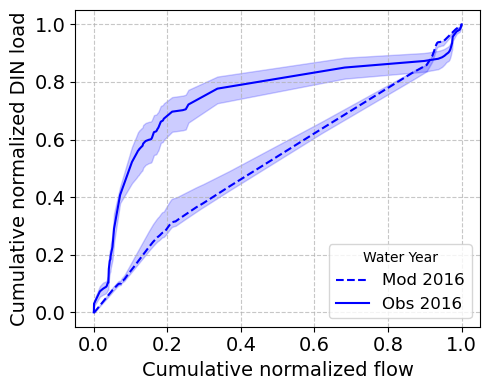

In [8]:
# Plot the double-mass plot for 2013-2015 with uncertainty ranges included
# Set up colors using Seaborn
unique_years = [2016]
color = 'blue'
plt.figure(figsize=(5, 4))
for i, water_year in enumerate(unique_years):
    year_data = df_mod[df_mod['water_year'] == water_year]
    # Cumulative sum for double-mass plot
    cum_flow = year_data['cum_flow']
    cum_din_load = year_data['cum_din_load']
    obs_year_data = df_obs[df_obs['water_year'] == water_year]
    obs_cum_flow = obs_year_data['cum_flow']
    obs_cum_din_load = obs_year_data['cum_din_load']
    plt.plot(cum_flow, cum_din_load, color=color, label=f'Mod {str(water_year)}', linestyle = '--')
    # Add the uncertainty band (shaded region)
    plt.fill_between(cum_flow, unctn_norm_ranges['mod'][str(water_year)][:, 0], \
                     unctn_norm_ranges['mod'][str(water_year)][:, 1], color=color, \
                        alpha=0.2)
    # Hide the legend
   #  plt.legend(fontsize = lab_fontsize).set_visible(False)
    plt.plot(obs_cum_flow, obs_cum_din_load, label=f'Obs {str(water_year)}', color=color)
    plt.fill_between(obs_cum_flow, unctn_norm_ranges['obs'][str(water_year)][:, 0], \
                     unctn_norm_ranges['obs'][str(water_year)][:, 1], color=color, \
                        alpha=0.2)

# plt.title('Double-Mass Plot for Each Water Year', fontsize = lab_fontsize)
plt.xlabel('Cumulative normalized flow', fontsize = 14)
plt.ylabel('Cumulative normalized DIN load', fontsize = 14)
plt.legend(title='Water Year', fontsize = 12)
plt.grid(True, linestyle='--', alpha=0.7)  # Dashed grid lines
plt.tick_params(axis= 'both', labelsize=14)
plt.tight_layout()
plt.savefig(f'{fig_dir}MvCurve2016WithUnctn.png', format = 'png', dpi=300)